<a href="https://colab.research.google.com/github/mrpiay/mrbeam/blob/main/mrbeam_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install mrbeam framework**

In [1]:
! git clone https://github.com/mrpiay/mrbeam.git

Cloning into 'mrbeam'...
remote: Enumerating objects: 574, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 574 (delta 16), reused 0 (delta 0), pack-reused 538
Receiving objects: 100% (574/574), 57.35 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [ ]:
! wget https://github.com/liamedeiros/ehtplot/archive/refs/heads/master.zip
! unzip master.zip -d .
! wget https://github.com/achael/eht-imaging/archive/refs/tags/v1.2.7.zip
! unzip v1.2.7.zip -d .
! pip install pygmo
! pip install ./ehtplot-master
! pip install ./eht-imaging-1.2.7
! pip install ./mrbeam/mr_beam/itreg
! pip install ./mrbeam/mr_beam/libwise-0.4.7-light
! pip install ./mrbeam/mr_beam/MSI
! pip install ./mrbeam/mr_beam/imagingbase
! pip install ./mrbeam/mr_beam/ga

# **Runtime -> Restart session (Ctrl+M) !**





# **Javier Example**

In [1]:
import pygmo as pg
import numpy as np
import GA.solver as solver
from GA.problems import EHT
import sys
import ehtim as eh
import matplotlib.pyplot as plt

Welcome to eht-imaging! v 1.2.7 



In [2]:
config_file = './mrbeam/mr_beam/mrpiay/ring_16_first_test.config'
outfile = './mrbeam/mr_beam/mrpiay/logger.log'

In [3]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters. WE WON'T USE THEM FOR NOW
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 3                 # Total compact flux density (Jy)
npix      = 16                # Number of pixels across the reconstructed image
fov       = 160*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities

#data weights
data_term = {'amp'    : 1.0,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['ALMA', 'APEX']    # baseline to measure zero-spacing flux
#rescaling = 0.04              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1.6*10**11]       #cbar-lims for interactive plotting (brightness temperature)

In [4]:
# Way of reading the config_file... if json is done, don't needed

# IMPORTANT!: Remember to change the path of img and uvf in your config

config = solver.read_config_params(config_file, 'EHT')

In [5]:
# Prior definition for the entropy regularizer

obs = eh.obsdata.load_uvfits(config['uvf'])
true_img = eh.image.load_fits(config['img'])
obs_sc = obs.copy()

prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (100*eh.RADPERUAS, 100*eh.RADPERUAS, 0, 100*eh.RADPERUAS, 100*eh.RADPERUAS))


Loading uvfits:  /content/mrbeam/mr_beam/mrpiay/ring_16.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  /content/mrbeam/mr_beam/mrpiay/ring_16.fits


In [6]:
# Getting the inputs

reg_term = config['reg_term']
data_term = config['data_term']
rescaling = config['rescaling']
zbl = config['zbl']

In [7]:
# Now, we create the MOP

EHTfit = EHT.EHT(obs, prior, data_term, reg_term, rescaling, zbl, npix**2)
EHTfit.setFit()

udp = pg.problem(EHTfit)

Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...


In [8]:
# Defining MOEA/D

def calculate_pop_size(grid_size):
    x = np.arange(grid_size+1)
    return int(np.sum(np.sum(np.meshgrid(x, x, x, x, x, x, x, x), axis=0) == grid_size))
pop_size = 84 #924 #config['grid_size'] If you have supercomputer, use the config, otherwise use this
seed = config['seed_initial']
pop = pg.population(udp, size=pop_size, seed=seed)


weights = pg.decomposition_weights(n_f=udp.get_nf(), n_w=len(pop), method=config['decomposition_method'], seed=config['decomposition_seed'])

gen = config['generations']
neighbours = config['neighbours']

algo = pg.algorithm(pg.moead(gen=gen, neighbours=neighbours, decomposition="weighted", weight_generation=config["decomposition_method"], seed=config['decomposition_seed']))

algo.set_verbosity(1)

maxit = 10 #100
stop = 1e-4
uv_zblcut2 = 0.1*10**9
res = obs_sc.res()

# This is for chosing a good starting point for the opti problem. Try both options and check difference
for i in range(len(pop)):
    pop.set_x(i, np.concatenate([obs.dirtyimage(true_img.xdim, true_img.fovx()).imvec/rescaling])) #dirty image as starting point
    # pop.set_x(i, np.concatenate([prior.imvec/rescaling])) # Gaussian

In [9]:
# Et voilà! evolve and getting the sol

pop = algo.evolve(pop)

fits, vectors = pop.get_f(), pop.get_x()

<ipython-input-10-5b424b0e8d1f>:6: DeprecationWarning: This function is deprecated. Please call randint(1, 83 + 1) instead
  randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(1)]


Loading fits image:  ./mrbeam/mr_beam/mrpiay/ring_16.fits


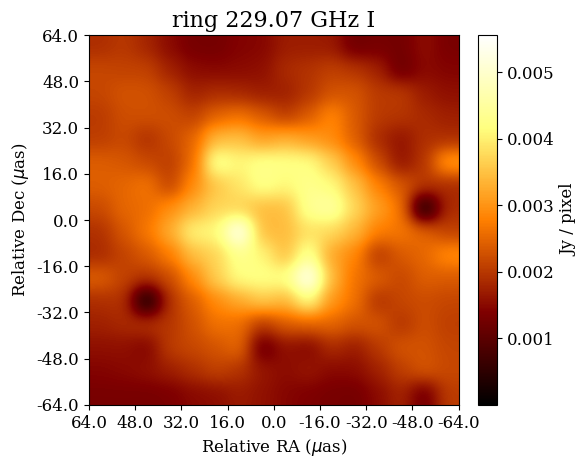

In [10]:
# And print some random solutions

save = False

#randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(100)]
randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(1)]
im=eh.image.load_fits('./mrbeam/mr_beam/mrpiay/ring_16.fits')
#im=eh.image.load_fits('synthetic_data/models/ring_16.fits')
for i in randsel:
   im.imvec = vectors[i]*rescaling
   im.display() #for saving im.display(export_pdf='path/name.png/pdf')
if save:
   import os
   os.system('rm %s_vectors*' % outfile)
   np.savetxt(outfile+'_fits.npy',fits)
   np.savetxt(outfile+'_vectors.npy',vectors)
   np.savetxt(outfile+'_weights.npy',weights)